In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dipy
from dipy.reconst.ivim import IvimModel
import dipy.core.gradients as dpg
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti_data

In [2]:
fraw, fbval, fbvec = get_fnames('ivim')

In [3]:
sim_bvecs = dpg.generate_bvecs(6)

In [4]:
data = load_nifti_data(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs, b0_threshold=0)

In [5]:
sim_bvecs = np.vstack([sim_bvecs]* len(gtab.bvals[1:]))

In [6]:
sim_bvecs = np.vstack([np.array([[0, 0, 0]]), sim_bvecs])

In [7]:
sim_bvals = np.hstack(list([[gtab.bvals[1:][i]] * 6] for i in range(len(gtab.bvals[1:])))).squeeze()

In [8]:
sim_bvals = np.hstack([0, sim_bvals])

In [9]:
sim_bvals.shape

(121,)

In [10]:
sim_bvecs.shape

(121, 3)

In [11]:
sim_gtab = gradient_table(sim_bvals, sim_bvecs, b0_threshold=0)

$\frac{S}{S_0} = \beta e^{-b \theta^t Q^{*}, \theta} + (1- \beta) e^{-b \theta^t Q \theta}$


In [12]:
from dipy.reconst.dti import lower_triangular, from_lower_triangular

In [13]:
theta = sim_gtab.bvecs

In [14]:
def ivim_tensor(b, *params): 
    """ 
    
    """
    beta = params[0]
    Q = from_lower_triangular(np.array(params[1:7]))
    Q_star = from_lower_triangular(np.array(params[7:]))
    return beta * np.exp(-b * np.diag(theta @ Q_star @ theta.T)) + (1 - beta) * np.exp(-b * np.diag(theta @ Q @ theta.T))
    

In [15]:
Q = lower_triangular(np.array([[0.0015, 0, 0], [0, 0.001, 0], [0, 0, 0.001]]))
Q_star = 10 * Q

#theta = np.array([[1, 0, 0]])
beta = 0.2

In [16]:
len(np.hstack((beta, Q, Q_star)))

13

In [17]:
params = np.hstack([beta, Q, Q_star])

In [18]:
np.array(params[1:7])

array([0.0015, 0.    , 0.001 , 0.    , 0.    , 0.001 ])

In [19]:
signal = ivim_tensor(sim_gtab.bvals, *params)

In [20]:
signal = signal+np.random.randn(signal.shape[0]) * 0.05

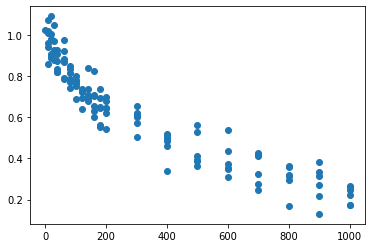

In [21]:
plt.plot(sim_gtab.bvals, signal, 'o')

In [22]:
from scipy.optimize import curve_fit

In [23]:
popt, pcov = curve_fit(ivim_tensor, sim_gtab.bvals, signal, p0=np.hstack((beta, Q, Q_star)))

In [24]:
popt

array([ 2.16016420e-01,  1.75402218e-03, -1.76792252e-07,  8.69354351e-04,
       -5.94597361e-05, -2.09863461e-05,  9.92739771e-04,  1.09292826e-02,
        1.23022006e-03,  1.14992238e-02,  1.41455092e-03, -1.70202796e-03,
        9.54493044e-03])

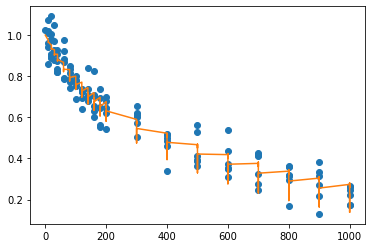

In [25]:
plt.plot(sim_gtab.bvals, signal, 'o')
plt.plot(sim_gtab.bvals, ivim_tensor(sim_gtab.bvals, *popt))

In [26]:
beta_hat = popt[0]
Q_hat = from_lower_triangular(np.array(popt[1:7]))
Q_star_hat = from_lower_triangular(np.array(popt[7:]))


In [27]:
from dipy.reconst import dti

In [28]:
beta_hat, dti.decompose_tensor(Q_hat), dti.decompose_tensor(Q_star_hat)

(0.2160164198945794,
 (array([0.00175864, 0.00099171, 0.00086577]),
  array([[-0.99699529,  0.07660967, -0.01146114],
         [-0.00162943, -0.16866618, -0.98567189],
         [ 0.0774451 ,  0.98269155, -0.16828421]])),
 (array([0.01263041, 0.01179354, 0.00754948]),
  array([[ 0.37355906,  0.79328237,  0.4807876 ],
         [ 0.87397293, -0.12730559, -0.46900384],
         [-0.31084553,  0.59539598, -0.74086347]])))

In [29]:
from dipy.sims.voxel import multi_tensor

In [212]:
mevals = np.array([[0.001, 0.0005, 0.0005], 
                   [0.1, 0.01, 0.01]])

angles = [(90, 0), (90, 0)]

In [213]:
perfusion_fraction = 0.2

In [214]:
signal = multi_tensor(sim_gtab, mevals=mevals, snr=1000, fractions=[100 * (1-perfusion_fraction), 
                                                                    perfusion_fraction * 100])[0]

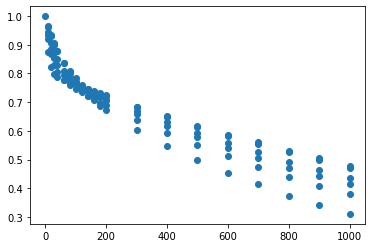

In [215]:
plt.plot(sim_gtab.bvals, signal, 'o')

In [216]:
model = IvimModel(sim_gtab, fit_method="trr")

/srv/conda/envs/notebook/lib/python3.7/site-packages/dipy/reconst/ivim.py:151: UserWarning: Bounds for this fit have been set from experiments and literature survey. To change the bounds, please input your bounds in model definition...
  warnings.warn(bounds_warning, UserWarning)


In [217]:
fit = model.fit(signal)

In [218]:
fit.D, fit.D_star, fit.perfusion_fraction

(array(0.00066732), array(0.0302777), array(0.18427975))

In [219]:
popt, pcov = curve_fit(ivim_tensor, sim_gtab.bvals, signal, p0=np.hstack((beta, Q, Q_star)))

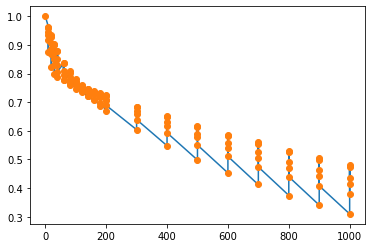

In [220]:
plt.plot(sim_gtab.bvals, ivim_tensor(sim_gtab.bvals, *popt))
plt.plot(sim_gtab.bvals, signal, 'o')

In [221]:
popt[0]

0.19976782958728312

In [222]:
beta_hat = popt[0]
Q_hat = from_lower_triangular(np.array(popt[1:7]))
Q_star_hat = from_lower_triangular(np.array(popt[7:]))


In [223]:
beta_hat, dti.decompose_tensor(Q_hat), dti.decompose_tensor(Q_star_hat)

(0.19976782958728312,
 (array([0.00099946, 0.00050105, 0.00050017]),
  array([[ 1.00484963e-04, -8.51241620e-01, -5.24773945e-01],
         [ 1.06094601e-03,  5.24773743e-01, -8.51241090e-01],
         [ 9.99999432e-01, -4.71219895e-04,  9.55853271e-04]])),
 (array([0.09811848, 0.01066169, 0.01047932]),
  array([[-0.99994558,  0.00833672, -0.00627213],
         [ 0.00344185,  0.83115799,  0.55602568],
         [-0.00984856, -0.55597383,  0.83114145]])))

In [224]:
evals_Q_hat = dti.decompose_tensor(Q_hat)[0]

In [225]:
np.mean(evals_Q_hat)

0.0006668933790903922

In [226]:
evals_Q_star_hat = dti.decompose_tensor(Q_star_hat)[0]

In [227]:
np.mean(evals_Q_star_hat)

0.039753162491509786

In [228]:
pdd_Q_hat = dti.decompose_tensor(Q_hat)[1][0]

In [229]:
pdd_Q_hat_star =  dti.decompose_tensor(Q_star_hat)[1][0]

In [230]:
pdd_Q_hat, pdd_Q_hat_star

(array([ 1.00484963e-04, -8.51241620e-01, -5.24773945e-01]),
 array([-0.99994558,  0.00833672, -0.00627213]))

In [231]:
np.rad2deg(np.arccos(np.dot(pdd_Q_hat, pdd_Q_hat_star)))

90.2237745004345

In [232]:
dti.fractional_anisotropy(evals_Q_star_hat)

0.8820897156383628

In [233]:
dti.fractional_anisotropy(evals_Q_hat)

0.4072889755488801

In [234]:
dti.mean_diffusivity(evals_Q_hat)

0.0006668933790903922

In [236]:
dti.mean_diffusivity(mevals[0])

0.0006666666666666666

In [235]:
dti.mean_diffusivity(evals_Q_star_hat)

0.039753162491509786

In [238]:
dti.mean_diffusivity(mevals[1])

0.04